In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Loading and Visualizing the Shape File

In [2]:
shape_file=gpd.read_file(r"C:\Users\pooja\Desktop\Sentinel 2A\crop_classification_mhow_road_Ambachandn.shp")

In [3]:
print(shape_file)

    Crop_class                                           geometry
0        chana  POLYGON ((75.83191 22.54246, 75.83235 22.54236...
1       Garlic  POLYGON ((75.83238 22.54234, 75.83324 22.54199...
2        chana  POLYGON ((75.83257 22.54307, 75.83244 22.54251...
3      G_Onion  POLYGON ((75.83362 22.54201, 75.83482 22.54171...
4        Onion  POLYGON ((75.83369 22.54307, 75.83491 22.54292...
..         ...                                                ...
142      onion  POLYGON ((75.91210 22.52371, 75.91407 22.52360...
143      wheat  POLYGON ((75.90728 22.52392, 75.90934 22.52337...
144     Garlic  POLYGON ((75.83306 22.54251, 75.83304 22.54296...
145      Wheat  POLYGON ((75.83066 22.54358, 75.83208 22.54395...
146    G_Onion  POLYGON ((75.83135 22.54346, 75.83171 22.54356...

[147 rows x 2 columns]


<Axes: >

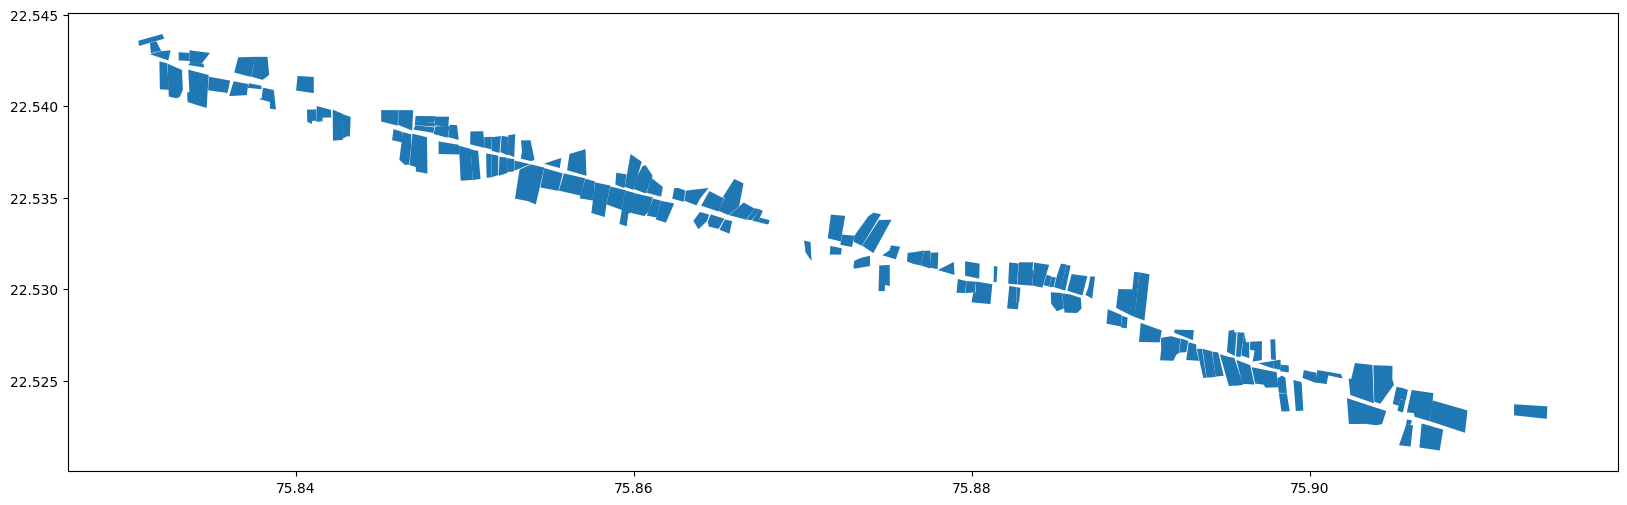

In [4]:
shape_file.plot(figsize=(20,20))

In [5]:
print(shape_file.columns)

Index(['Crop_class', 'geometry'], dtype='object')


<Axes: >

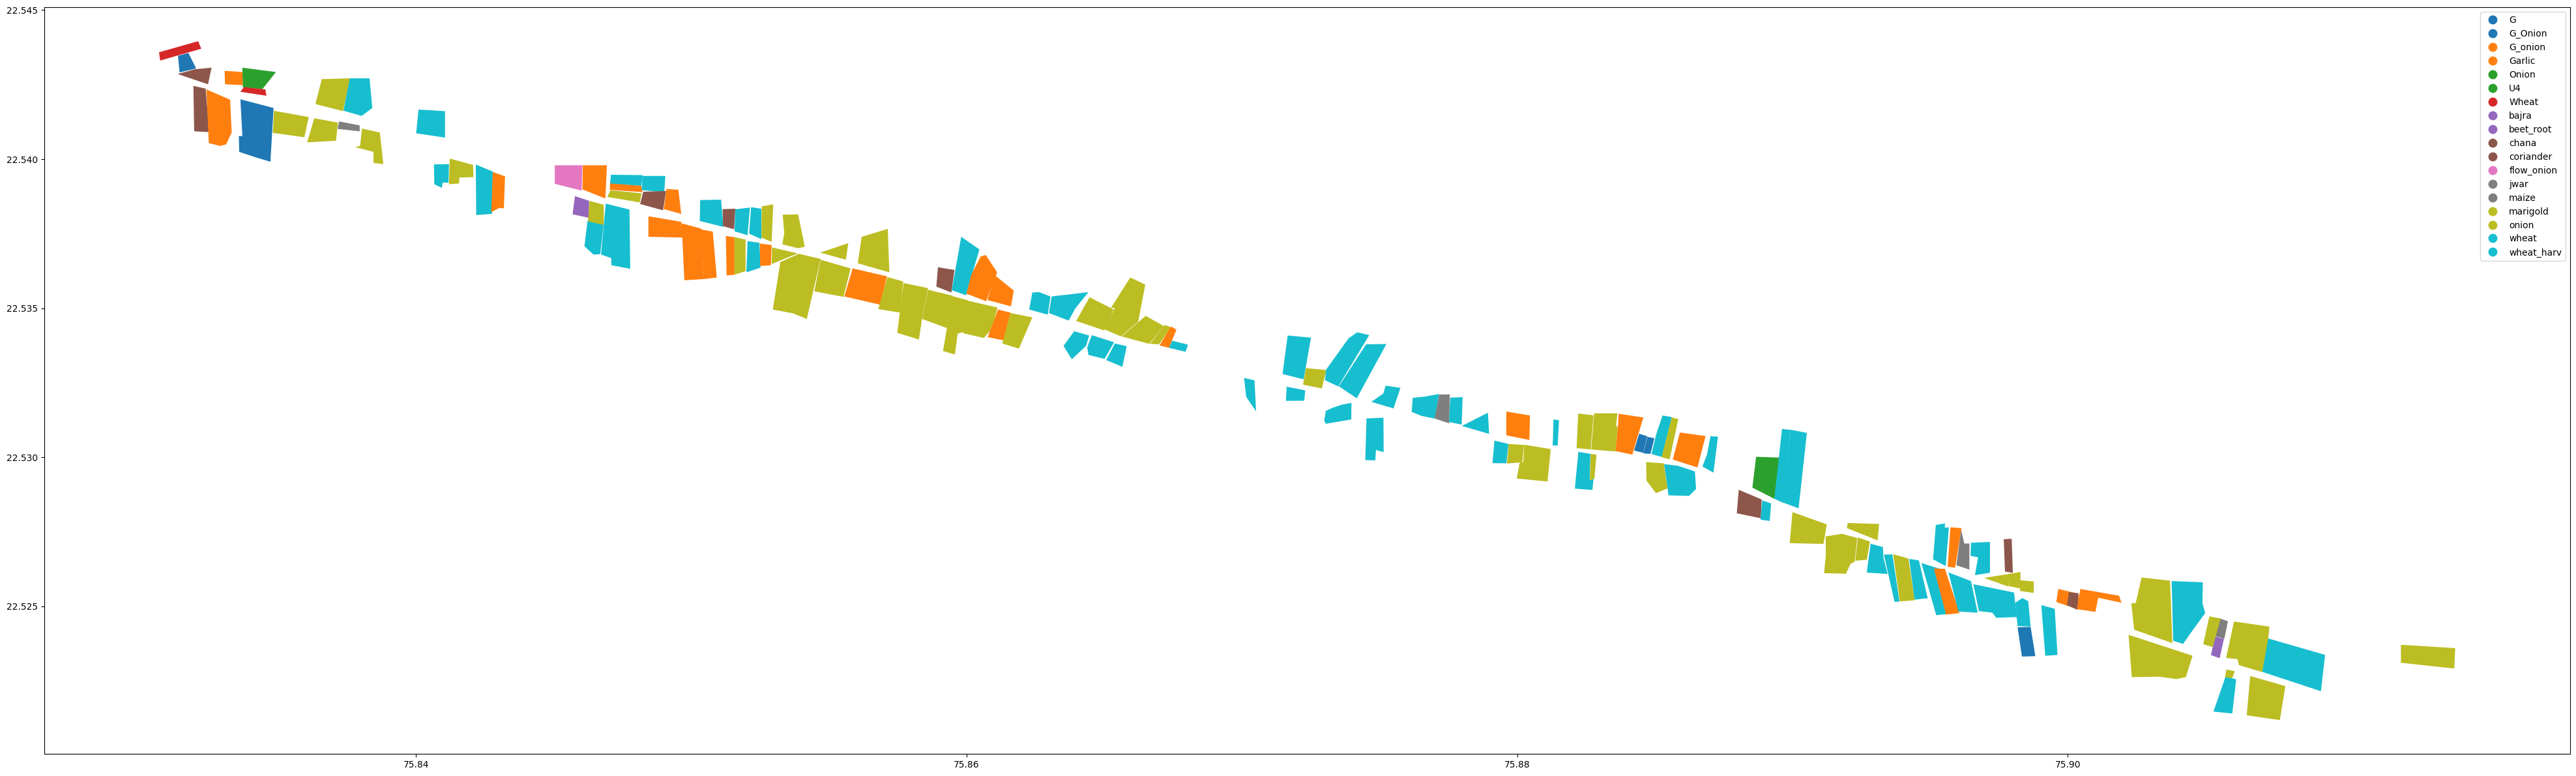

In [6]:
shape_file.plot(column='Crop_class',cmap=None,legend=True,figsize=(50,50))

# Identifying the boundaries of each Polygon in the Shape File

In [7]:
import geopandas as gpd

# Read the shapefile into a GeoDataFrame
gdf = gpd.read_file(r"C:\Users\pooja\Desktop\Sentinel 2A\crop_classification_mhow_road_Ambachandn.shp")

# Loop through each polygon in the GeoDataFrame
for i, row in gdf.iterrows():
    # Get the polygon object for this row
    poly = row['geometry']
    
    # Get the coordinates of the vertices and print them
    coords = poly.exterior.coords[:]
    print(f"Polygon {i} vertices:")
    for coord in coords:
        lat, lon = coord
        print(f"({lat}, {lon})")

Polygon 0 vertices:
(75.83191010964302, 22.542456063260794)
(75.83235488117217, 22.542363304405846)
(75.83248400839032, 22.540905657070592)
(75.83193880458037, 22.5409321598868)
(75.83191010964302, 22.542456063260794)
Polygon 1 vertices:
(75.83238357610954, 22.5423368018644)
(75.83324442423049, 22.541992268362662)
(75.83324442423049, 22.541992268362662)
(75.83330181410521, 22.540892405660582)
(75.83310094954365, 22.540494862768753)
(75.83288573751342, 22.540441856963337)
(75.83246966092162, 22.540534617109454)
(75.83238357610954, 22.5423368018644)
Polygon 2 vertices:
(75.8325700932024, 22.543065619899814)
(75.83244096598428, 22.5425090682928)
(75.83133621089571, 22.542853600504603)
(75.83196749951775, 22.54301261508154)
(75.8325700932024, 22.543065619899814)
Polygon 3 vertices:
(75.83361745841623, 22.5420055196671)
(75.83482264578556, 22.541713990675813)
(75.8347078660361, 22.539911797789888)
(75.8347078660361, 22.539911797789888)
(75.83417700969483, 22.540057564265478)
(75.83357441601

# Downloading the Sentinel 2 Data 

Downloaded the requisite files using the Sentinel API. The API allows for me to specify the dates, as well as the coordinates of the shape file. This downloads only the requisite tiles, and makes it easier to clean up, when it comes to extracting multiple reflectance values. 


Currently commented out, since I've already downloaded the data- which takes quite a bit of time

In [ ]:
'''from sentinelsat import SentinelAPI, geojson_to_wkt
from shapely.geometry import shape
import geopandas as gpd

# Set up the API
api = SentinelAPI('poojapremnath', 'Pooj@2003ssn', 'https://scihub.copernicus.eu/dhus')


shapefile_path = r'C:\Users\pooja\Desktop\Sentinel 2A\crop_classification_mhow_road_Ambachandn.shp'

# Read in the shapefile as a GeoDataFrame
gdf = gpd.read_file(shapefile_path)


for index, row in gdf.iterrows():
    
    wkt = geojson_to_wkt(row.geometry.__geo_interface__)
    
    
    date_range = ('2023-02-15T00:00:00Z', '2023-02-28T23:59:59Z')  
    platform = 'Sentinel-2'
    product_type = 'S2MSI2A'
    cloudcover_percentage = (0, 10)  # Change as needed
    
    
    products = api.query(wkt,
                         date=date_range,
                         platformname=platform,
                         producttype=product_type,
                         cloudcoverpercentage=cloudcover_percentage)
    
    
    api.download_all(products)'''

This section processes the ZIP folders that come from the Sentinel 2 data download. It extracts the ZIP files, and gives access to the .SAFE files

**I have used data from the second half of February (15th to 28th February 2023). There are 4 tiles that are downloaded for this period. **

In [7]:
import os
import zipfile

# Define path to the directory containing the downloaded granules
granules_dir = r'C:\Users\pooja\Desktop\Sentinel 2A'

# Loop over the granules and extract the zip files
for granule_name in os.listdir(granules_dir):
    granule_path = os.path.join(granules_dir, granule_name)
    if granule_name.endswith('.zip'):
        with zipfile.ZipFile(granule_path, 'r') as zip_ref:
            zip_ref.extractall(granules_dir)
        os.remove(granule_path)

# Clipping the Sentinel Data to that of the Shape File

In this section, I have used the rasterio module to map the data from the Sentinel Download, to the shape of the Shape File. This is the outline of the block below:

1. Initially, I have to make sure that the Shape file and the Sentinel Data are in the same Coordinate Reference System (CRS). If not, an appropriate mapping is done. 

2. I recursively iterate through the folders on my system to identify the required images, from each tile. I have used the Red, Green, Blue and NIR Bands. 

3. I clip the Sentinel Data to that of the shape file using the mask function. I've also included a try-catch error detection block in case, there are regions that cannot be found. (Upon running, it is clear that all the fields in the Sentinel Data are mapped to the shape file as well, so that is not an issue). 



In [1]:
import os
import glob
import rasterio
from rasterio.plot import show
import numpy as np
import geopandas as gpd
from rasterio.mask import mask
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

path = r'C:\Users\pooja\Desktop\Sentinel 2A'

# Read in the shapefile
shapefile_path = r'C:\Users\pooja\Desktop\Sentinel 2A\crop_classification_mhow_road_Ambachandn.shp'
gdf = gpd.read_file(shapefile_path)


if gdf.crs != rasterio.crs.CRS.from_epsg(32643):
    gdf = gdf.to_crs(rasterio.crs.CRS.from_epsg(32643))


folders = glob.glob(os.path.join(path, '**/*.SAFE'), recursive=True)



# Loop through each .SAFE folder
for folder in folders:
    
    band_paths = [os.path.join(folder, 'GRANULE', granule, 'IMG_DATA', 'R10m', file) for granule in os.listdir(os.path.join(folder, 'GRANULE')) for file in os.listdir(os.path.join(folder, 'GRANULE', granule, 'IMG_DATA', 'R10m')) if file.endswith('_B02_10m.jp2') or file.endswith('_B03_10m.jp2') or file.endswith('_B04_10m.jp2') or file.endswith('_B08_10m.jp2')]
    
   
    arrs = []
    for band_path in band_paths:
        with rasterio.open(band_path) as src:
            arrs.append(src.read(1))
            # Print out the CRS of the raster data
            print(src.crs)
    arr = np.stack(arrs, axis=-1)
    
    # Loop through each feature in the shapefile
    for index, row in gdf.iterrows():
        # Clip the array to the extent of the feature
        try:
            out_image, out_transform = mask(rasterio.open(band_paths[0]), [row.geometry], crop=True)
        except ValueError:
            print(f"Skipping feature {index} as it does not overlap raster")
            continue
        
        for i in range(1, arr.shape[-1]):
            try:
                band_image, _ = mask(rasterio.open(band_paths[i]), [row.geometry], crop=True)
            except ValueError:
                print(f"Skipping feature {index} as it does not overlap raster")
                continue
            out_image = np.dstack((out_image, band_image))
        
        
        

EPSG:32643
EPSG:32643
EPSG:32643
EPSG:32643
EPSG:32643
EPSG:32643
EPSG:32643
EPSG:32643
EPSG:32643
EPSG:32643
EPSG:32643
EPSG:32643
EPSG:32643
EPSG:32643
EPSG:32643
EPSG:32643


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\pooja\\Desktop\\Sentinel 2A\\S2A_MSIL2A_20230218T052901_N0509_R105_T43QEE_20230218T092158.SAFE\\manifest.safe\\GRANULE'

# NDVI and Crop Masks

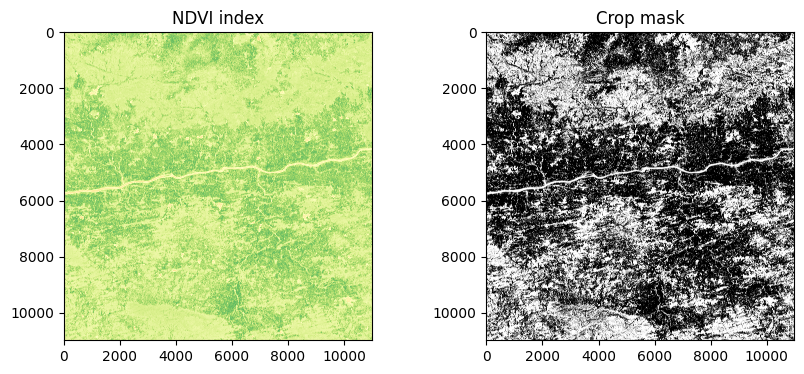

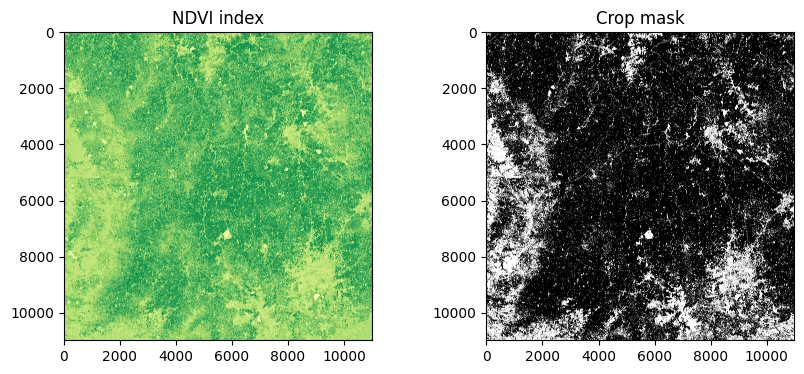

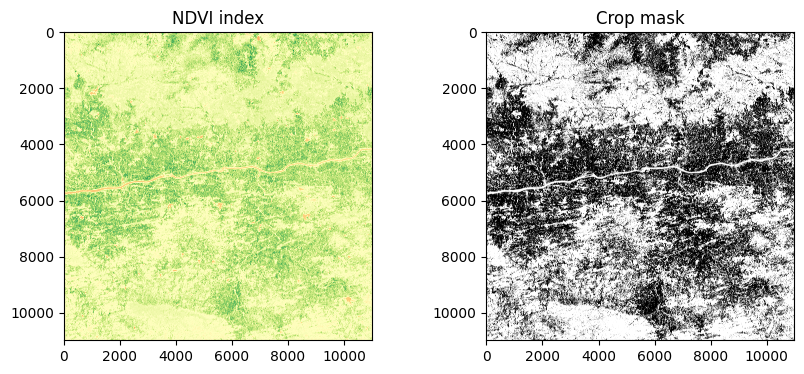

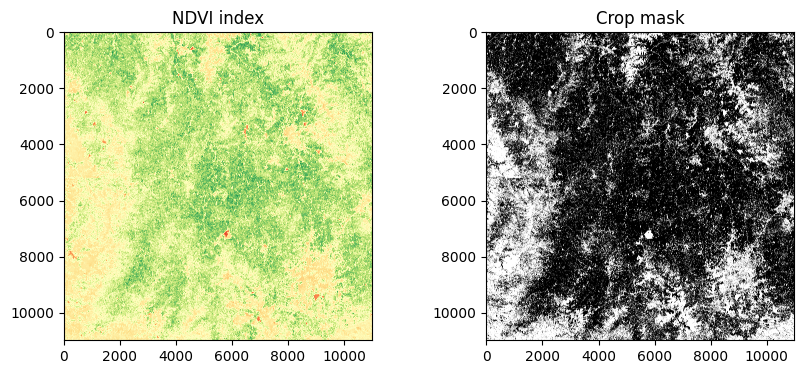

No suitable files found in C:\Users\pooja\Desktop\Sentinel 2A\S2A_MSIL2A_20230218T052901_N0509_R105_T43QEE_20230218T092158.SAFE\manifest.safe
No suitable files found in C:\Users\pooja\Desktop\Sentinel 2A\S2A_MSIL2A_20230218T052901_N0509_R105_T43QEF_20230218T092158.SAFE\manifest.safe
No suitable files found in C:\Users\pooja\Desktop\Sentinel 2A\S2A_MSIL2A_20230228T052751_N0509_R105_T43QEE_20230228T092855.SAFE\manifest.safe
No suitable files found in C:\Users\pooja\Desktop\Sentinel 2A\S2A_MSIL2A_20230228T052751_N0509_R105_T43QEF_20230228T092855.SAFE\manifest.safe


In [26]:
import os
import glob
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt

path = r'C:\Users\pooja\Desktop\Sentinel 2A'

# Loop through each SAFE folder
for folder in glob.glob(os.path.join(path, '**/*.SAFE'), recursive=True):
    
    # Find the paths to the Red and NIR bands
    try:
        red_path = glob.glob(os.path.join(folder, 'GRANULE', '*', 'IMG_DATA', 'R10m', '*_B04_10m.jp2'))[0]
        nir_path = glob.glob(os.path.join(folder, 'GRANULE', '*', 'IMG_DATA', 'R10m', '*_B08_10m.jp2'))[0]
    except IndexError:
        print(f"No suitable files found in {folder}")
        continue
    
    # Open the Red and NIR bands as Rasterio datasets
    with rasterio.open(red_path) as red_ds, rasterio.open(nir_path) as nir_ds:
        # Read in the Red and NIR bands as numpy arrays
        red = red_ds.read(1).astype(np.float32)
        nir = nir_ds.read(1).astype(np.float32)
        
        # Calculate the NDVI index
        ndvi = (nir - red) / (nir + red)
        
        # Apply a threshold to the NDVI values to separate crops from non-crops
        threshold = 0.2
        crop_mask = ndvi > threshold
        
        # Plot the NDVI index and the crop mask
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))
        show(ndvi, cmap='RdYlGn', ax=ax1)
        ax1.set_title('NDVI index')
        show(crop_mask, cmap='binary', ax=ax2)
        ax2.set_title('Crop mask')
        plt.show()


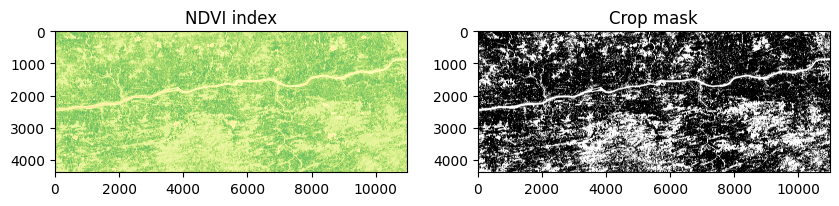

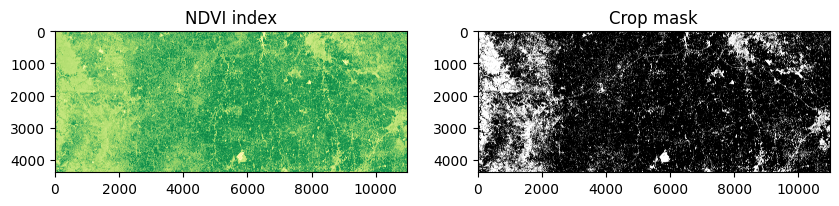

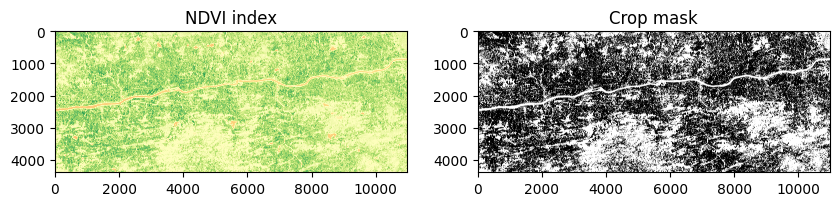

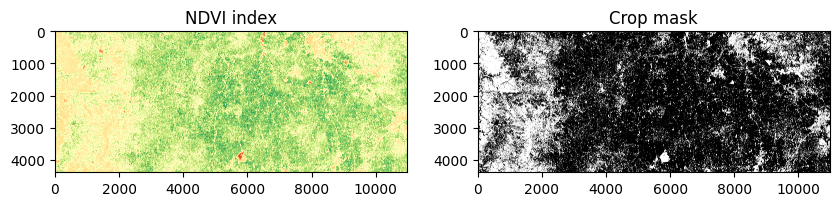

No suitable files found in C:\Users\pooja\Desktop\Sentinel 2A\S2A_MSIL2A_20230218T052901_N0509_R105_T43QEE_20230218T092158.SAFE\manifest.safe
No suitable files found in C:\Users\pooja\Desktop\Sentinel 2A\S2A_MSIL2A_20230218T052901_N0509_R105_T43QEF_20230218T092158.SAFE\manifest.safe
No suitable files found in C:\Users\pooja\Desktop\Sentinel 2A\S2A_MSIL2A_20230228T052751_N0509_R105_T43QEE_20230228T092855.SAFE\manifest.safe
No suitable files found in C:\Users\pooja\Desktop\Sentinel 2A\S2A_MSIL2A_20230228T052751_N0509_R105_T43QEF_20230228T092855.SAFE\manifest.safe


In [7]:
import os
import glob
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt

path = r'C:\Users\pooja\Desktop\Sentinel 2A'

# Loop through each SAFE folder
for folder in glob.glob(os.path.join(path, '**/*.SAFE'), recursive=True):
    
    # Find the paths to the Red and NIR bands
    try:
        red_path = glob.glob(os.path.join(folder, 'GRANULE', '*', 'IMG_DATA', 'R10m', '*_B04_10m.jp2'))[0]
        nir_path = glob.glob(os.path.join(folder, 'GRANULE', '*', 'IMG_DATA', 'R10m', '*_B08_10m.jp2'))[0]
    except IndexError:
        print(f"No suitable files found in {folder}")
        continue
    
    # Open the Red and NIR bands as Rasterio datasets
    with rasterio.open(red_path) as red_ds, rasterio.open(nir_path) as nir_ds:
        # Read in the Red and NIR bands as numpy arrays
        red = red_ds.read(1).astype(np.float32)
        nir = nir_ds.read(1).astype(np.float32)

        # Crop the top and bottom 30% of the image
        crop_top = int(red.shape[0] * 0.3)
        crop_bottom = int(red.shape[0] * 0.7)
        red = red[crop_top:crop_bottom, :]
        nir = nir[crop_top:crop_bottom, :]

        # Calculate the NDVI index
        ndvi = (nir - red) / (nir + red)
        
        # Apply a threshold to the NDVI values to separate crops from non-crops
        threshold = 0.2
        crop_mask = ndvi > threshold
        
        # Plot the NDVI index and the crop mask
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))
        show(ndvi, cmap='RdYlGn', ax=ax1)
        ax1.set_title('NDVI index')
        show(crop_mask, cmap='binary', ax=ax2)
        ax2.set_title('Crop mask')
        plt.show()


In [4]:
import os
import glob
import rasterio
import numpy as np
import csv

path = r'C:\Users\pooja\Desktop\Sentinel 2A'
output_file = "lat_long.csv"

# Open the output CSV file for writing
with open(output_file, mode='w', newline='') as output_csv:
    # Create a writer object to write rows to the CSV file
    writer = csv.writer(output_csv)

    # Write the header row to the CSV file
    writer.writerow(['Latitude', 'Longitude', 'Classification'])

    # Loop through each SAFE folder
    for folder in glob.glob(os.path.join(path, '**/*.SAFE'), recursive=True):

        # Find the paths to the Red and NIR bands
        try:
            red_path = glob.glob(os.path.join(folder, 'GRANULE', '*', 'IMG_DATA', 'R10m', '*_B04_10m.jp2'))[0]
            nir_path = glob.glob(os.path.join(folder, 'GRANULE', '*', 'IMG_DATA', 'R10m', '*_B08_10m.jp2'))[0]
        except IndexError:
            print(f"No suitable files found in {folder}")
            continue

        # Open the Red and NIR bands as Rasterio datasets
        with rasterio.open(red_path) as red_ds, rasterio.open(nir_path) as nir_ds:
            # Read in the Red and NIR bands as numpy arrays
            red = red_ds.read(1).astype(np.float32)
            nir = nir_ds.read(1).astype(np.float32)

            # Crop the top and bottom 30% of the image
            crop_top = int(red.shape[0] * 0.3)
            crop_bottom = int(red.shape[0] * 0.7)
            red = red[crop_top:crop_bottom, :]
            nir = nir[crop_top:crop_bottom, :]

            # Calculate the NDVI index
            ndvi = (nir - red) / (nir + red)

            # Apply a threshold to the NDVI values to separate crops from non-crops
            threshold = 0.2
            crop_mask = ndvi > threshold

            # Get the geospatial transform from the Red band dataset
            transform = red_ds.transform

            # Loop through each pixel in the crop mask
            for row in range(crop_mask.shape[0]):
                for col in range(crop_mask.shape[1]):
                    # Compute the latitude and longitude for the current pixel
                    lon, lat = transform * (col, row)

                    # Write the latitude, longitude, and classification to the CSV file
                    writer.writerow([lat, lon, crop_mask[row, col]])
               
            break
        


In [5]:
import os
import glob
import rasterio
import numpy as np
import csv
import pyproj

path = r'C:\Users\pooja\Desktop\Sentinel 2A'
output_file = "coordinates.csv"

# Define the UTM zone and WGS84 coordinate reference systems
utm_zone = '18N'
utm_crs = f'+proj=utm +zone={utm_zone} +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
wgs84_crs = pyproj.CRS('EPSG:4326')

# Open the output CSV file for writing
with open(output_file, mode='w', newline='') as output_csv:
    # Create a writer object to write rows to the CSV file
    writer = csv.writer(output_csv)

    # Write the header row to the CSV file
    writer.writerow(['Latitude', 'Longitude', 'Classification'])

    # Loop through each SAFE folder
    for folder in glob.glob(os.path.join(path, '**/*.SAFE'), recursive=True):

        # Find the paths to the Red and NIR bands
        try:
            red_path = glob.glob(os.path.join(folder, 'GRANULE', '*', 'IMG_DATA', 'R10m', '*_B04_10m.jp2'))[0]
            nir_path = glob.glob(os.path.join(folder, 'GRANULE', '*', 'IMG_DATA', 'R10m', '*_B08_10m.jp2'))[0]
        except IndexError:
            print(f"No suitable files found in {folder}")
            continue

        # Open the Red and NIR bands as Rasterio datasets
        with rasterio.open(red_path) as red_ds, rasterio.open(nir_path) as nir_ds:
            # Read in the Red and NIR bands as numpy arrays
            red = red_ds.read(1).astype(np.float32)
            nir = nir_ds.read(1).astype(np.float32)

            # Crop the top and bottom 30% of the image
            crop_top = int(red.shape[0] * 0.3)
            crop_bottom = int(red.shape[0] * 0.7)
            red = red[crop_top:crop_bottom, :]
            nir = nir[crop_top:crop_bottom, :]

            # Calculate the NDVI index
            ndvi = (nir - red) / (nir + red)

            # Apply a threshold to the NDVI values to separate crops from non-crops
            threshold = 0.2
            crop_mask = ndvi > threshold

            # Get the geospatial transform from the Red band dataset
            transform = red_ds.transform

            # Define the UTM to WGS84 transformer
            transformer = pyproj.Transformer.from_crs(utm_crs, wgs84_crs)

            # Loop through each pixel in the crop mask
            for row in range(crop_mask.shape[0]):
                for col in range(crop_mask.shape[1]):
                    # Compute the latitude and longitude for the current pixel
                    x, y = transform * (col, row)
                    lon, lat = transformer.transform(x, y)

                    # Write the latitude, longitude, and classification to the CSV file
                    writer.writerow([lat, lon, crop_mask[row, col]])
            break


CRSError: Invalid projection: +proj=utm +zone=18N +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs: (Internal Proj Error: proj_create: Error 1027 (Invalid value for an argument): utm: Invalid value for zone)

In [28]:
'''# Loop through each Sentinel-2 tile
for folder in glob.glob(os.path.join(path, '**/*.SAFE'), recursive=True):
    # Construct the file paths for each band
    band_paths = [os.path.join(folder, 'GRANULE', granule, 'IMG_DATA', 'R10m', file) for granule in os.listdir(os.path.join(folder, 'GRANULE')) for file in os.listdir(os.path.join(folder, 'GRANULE', granule, 'IMG_DATA', 'R10m')) if file.endswith('_B02_10m.jp2') or file.endswith('_B03_10m.jp2') or file.endswith('_B04_10m.jp2') or file.endswith('_B08_10m.jp2')]

    # Read in the bands and stack them into a single array
    arrs = []
    for band_path in band_paths:
        with rasterio.open(band_path) as src:
            arrs.append(src.read(1))
    arr = np.stack(arrs, axis=-1)

    # Match the shapefile coordinates to the Sentinel-2 tile
    data_rows = []
    for index, row in gdf.iterrows():
        try:
            out_image, out_transform = mask(rasterio.open(band_paths[0]), [row.geometry], crop=True)
        except ValueError:
            print(f"Skipping feature {index} as it does not overlap raster")
            continue

        for i in range(1, arr.shape[-1]):
            try:
                band_image, _ = mask(rasterio.open(band_paths[i]), [row.geometry], crop=True)
            except ValueError:
                print(f"Skipping feature {index} as it does not overlap raster")
                continue
            out_image = np.dstack((out_image, band_image))

        crop_class = row['Crop_class']
        latitude = row.geometry.centroid.y
        longitude = row.geometry.centroid.x

        data_rows.extend([(crop_class, latitude, longitude) + tuple(pixel) for pixel in out_image.reshape(-1, 4)])

    # Create a pandas DataFrame from the data rows
    df = pd.DataFrame(data_rows, columns=['Crop_class', 'Latitude', 'Longitude'] + [f'{band}_refl' for band in band_names])

    # Write the DataFrame to a CSV file
    output_csv_path = os.path.join(folder, 'output.csv')
    df.to_csv(output_csv_path, index=False)
    '''


'# Loop through each Sentinel-2 tile\nfor folder in glob.glob(os.path.join(path, \'**/*.SAFE\'), recursive=True):\n    # Construct the file paths for each band\n    band_paths = [os.path.join(folder, \'GRANULE\', granule, \'IMG_DATA\', \'R10m\', file) for granule in os.listdir(os.path.join(folder, \'GRANULE\')) for file in os.listdir(os.path.join(folder, \'GRANULE\', granule, \'IMG_DATA\', \'R10m\')) if file.endswith(\'_B02_10m.jp2\') or file.endswith(\'_B03_10m.jp2\') or file.endswith(\'_B04_10m.jp2\') or file.endswith(\'_B08_10m.jp2\')]\n\n    # Read in the bands and stack them into a single array\n    arrs = []\n    for band_path in band_paths:\n        with rasterio.open(band_path) as src:\n            arrs.append(src.read(1))\n    arr = np.stack(arrs, axis=-1)\n\n    # Match the shapefile coordinates to the Sentinel-2 tile\n    data_rows = []\n    for index, row in gdf.iterrows():\n        try:\n            out_image, out_transform = mask(rasterio.open(band_paths[0]), [row.geometr

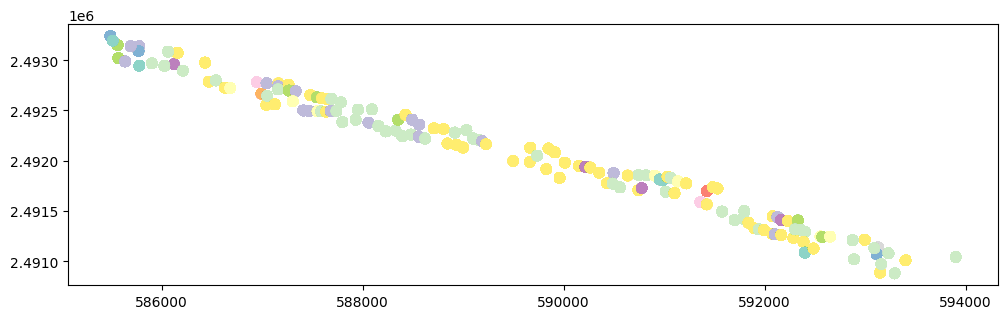

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Read the output CSV file into a pandas DataFrame
df = pd.read_csv("C:/Users/pooja/Desktop/Sentinel 2A/output_f1.csv")

# Convert the pandas DataFrame to a geopandas GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

# Plot the GeoDataFrame with color-coded crop classes
gdf.plot(column='Crop_class', cmap='Set3', markersize=50, figsize=(12, 12))

# Show the plot
plt.show()


In [6]:
crop_types = df['Crop_class'].unique()


for crop_type in crop_types:
    count = df[df['Crop_class'] == crop_type].shape[0]
    print(f'{crop_type}: {count} records')


KeyError: 'Crop_class'

# ML Modeling Techniques

In [24]:
crop_types = df['Crop_class'].unique()
print(crop_types)

['chana' 'Garlic' 'Wheat' 'Onion' 'onion' 'maize' 'wheat' 'beet_root'
 'flow_onion' 'wheat_harv' 'marigold' 'coriander' 'U4' 'jwar' 'bajra']


# Random Forest on all the Crops

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


ndf = ndf[['Crop_class', 'B02_refl', 'B03_refl', 'B04_refl', 'B08_refl']]

le = LabelEncoder()
ndf['Crop_class'] = le.fit_transform(ndf['Crop_class'])

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(ndf.drop('Crop_class', axis=1), ndf['Crop_class'], test_size=0.4, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)


while True:
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Validation accuracy: {val_accuracy}")

    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Testing accuracy: {test_accuracy}")

    if test_accuracy > 0.85:
        break

    
    misclassified_indices = [i for i, (actual, predicted) in enumerate(zip(y_test, y_test_pred)) if actual != predicted]

   
    X_train = pd.concat([X_train, X_test.iloc[misclassified_indices]])
    y_train = pd.concat([y_train, y_test.iloc[misclassified_indices]])

# Fit the model on the combined training and validation sets
model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))


y_pred = model.predict(ndf.drop('Crop_class', axis=1))


pred_df = pd.DataFrame({'Crop_class_pred': y_pred, 'Index': ndf.index})


ndf_pred = pd.merge(ndf, pred_df, left_index=True, right_on='Index')

# Compute the accuracy for each crop type
accuracy_dict = {}
for crop in le.classes_:
    indices = ndf_pred[ndf_pred['Crop_class'] == le.transform([crop])[0]].index
    accuracy = accuracy_score(ndf_pred.loc[indices, 'Crop_class'], ndf_pred.loc[indices, 'Crop_class_pred'])
    accuracy_dict[crop] = accuracy


test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Final testing accuracy: {test_accuracy}")
print("Accuracy of classification for each crop type:")
print(accuracy_dict)



Validation accuracy: 0.4711363044044827
Testing accuracy: 0.47171507877555807
Validation accuracy: 0.47888975762314306
Testing accuracy: 0.8451855037335314
Validation accuracy: 0.4971331769611676
Testing accuracy: 0.9396379842839829
Final testing accuracy: 0.9396379842839829
Accuracy of classification for each crop type:
{0: 0.9026924202516827, 1: 0.8469387755102041, 2: 0.912621359223301, 3: 0.9225324419976406, 4: 0.9423076923076923, 5: 0.9182692307692307, 6: 0.9513641755634639, 7: 0.9527777777777777, 8: 0.9592391304347826, 9: 0.8125, 10: 0.9121522693997072, 11: 0.9652777777777778, 12: 0.9446142253108385, 13: 0.9397601026866729, 14: 0.9470899470899471}


In [31]:
print(pred_df)

       Crop_class_pred  Index
0                    6      0
1                   13      1
2                   12      2
3                    6      3
4                    6      5
...                ...    ...
63942                3  83303
63943                3  83304
63944                3  83306
63945                3  83308
63946                3  83310

[63947 rows x 2 columns]


In [28]:
accuracy_dict = {}
for crop_code in le.classes_:
    crop_name = le.inverse_transform([crop_code])[0]
    indices = ndf_pred[ndf_pred['Crop_class'] == crop_code].index
    accuracy = accuracy_score(ndf_pred.loc[indices, 'Crop_class'], ndf_pred.loc[indices, 'Crop_class_pred'])
    accuracy_dict[crop_name] = accuracy

In [29]:
print(accuracy_dict)

{0: 0.9026924202516827, 1: 0.8469387755102041, 2: 0.912621359223301, 3: 0.9225324419976406, 4: 0.9423076923076923, 5: 0.9182692307692307, 6: 0.9513641755634639, 7: 0.9527777777777777, 8: 0.9592391304347826, 9: 0.8125, 10: 0.9121522693997072, 11: 0.9652777777777778, 12: 0.9446142253108385, 13: 0.9397601026866729, 14: 0.9470899470899471}


In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

ndf = ndf[['Crop_class', 'B02_refl', 'B03_refl', 'B04_refl', 'B08_refl']]

le = LabelEncoder()
ndf['Crop_class'] = le.fit_transform(ndf['Crop_class'])

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(ndf.drop('Crop_class', axis=1), ndf['Crop_class'], test_size=0.4, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)

# Iterate to improve testing accuracy
while True:
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Validation accuracy: {val_accuracy}")

    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Testing accuracy: {test_accuracy}")

    if test_accuracy > 0.85:
        break

    # Find the indices of crops that were misclassified in the testing set
    misclassified_indices = [i for i, (actual, predicted) in enumerate(zip(y_test, y_test_pred)) if actual != predicted]

    # Add the misclassified crops to the training set
    X_train = pd.concat([X_train, X_test.iloc[misclassified_indices]])
    y_train = pd.concat([y_train, y_test.iloc[misclassified_indices]])

# Fit the final model on the combined training and validation sets
model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

# Predict the crop types for the entire dataset
y_pred = model.predict(ndf.drop('Crop_class', axis=1))

# Create a DataFrame with the predicted crop class and the corresponding index
pred_df = pd.DataFrame({'Crop_class_pred': y_pred, 'Index': ndf.index})

# Merge the predicted crop class DataFrame with the original DataFrame
ndf_pred = pd.merge(ndf, pred_df, left_index=True, right_on='Index')

# Compute the accuracy for each crop type
accuracy_dict = {}
for crop in le.classes_:
    crop_name = le.inverse_transform([crop])[0]
    indices = ndf_pred[ndf_pred['Crop_class'] == crop].index
    accuracy = accuracy_score(ndf_pred.loc[indices, 'Crop_class'], ndf_pred.loc[indices, 'Crop_class_pred'])
    accuracy_dict[crop_name] = accuracy

# Print the final testing accuracy and the accuracy for each crop type
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Final testing accuracy: {test_accuracy}")
print("Accuracy of classification for each crop type:")
print(accuracy_dict)


Validation accuracy: 0.4711363044044827
Testing accuracy: 0.47171507877555807
Validation accuracy: 0.47888975762314306
Testing accuracy: 0.8451855037335314
Validation accuracy: 0.4971331769611676
Testing accuracy: 0.9396379842839829
Final testing accuracy: 0.9396379842839829
Accuracy of classification for each crop type:
{0: 0.9026924202516827, 1: 0.8469387755102041, 2: 0.912621359223301, 3: 0.9225324419976406, 4: 0.9423076923076923, 5: 0.9182692307692307, 6: 0.9513641755634639, 7: 0.9527777777777777, 8: 0.9592391304347826, 9: 0.8125, 10: 0.9121522693997072, 11: 0.9652777777777778, 12: 0.9446142253108385, 13: 0.9397601026866729, 14: 0.9470899470899471}


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


ndf = ndf[['Crop_class', 'B02_refl', 'B03_refl', 'B04_refl', 'B08_refl']]

le = LabelEncoder()
ndf['Crop_class'] = le.fit_transform(ndf['Crop_class'])

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(ndf.drop('Crop_class', axis=1), ndf['Crop_class'], test_size=0.4, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=42)

model = SVC(kernel='linear', C=1, random_state=42)

# Iterate to improve testing accuracy
while True:
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Validation accuracy: {val_accuracy}")

    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Testing accuracy: {test_accuracy}")

    if test_accuracy > 0.85:
        break

    # Find the indices of crops that were misclassified in the testing set
    misclassified_indices = [i for i, (actual, predicted) in enumerate(zip(y_test, y_test_pred)) if actual != predicted]

    # Add the misclassified crops to the training set
    X_train = pd.concat([X_train, X_test.iloc[misclassified_indices]])
    y_train = pd.concat([y_train, y_test.iloc[misclassified_indices]])

# Fit the final model on the combined training and validation sets
model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

# Predict the crop types for the entire dataset
y_pred = model.predict(ndf.drop('Crop_class', axis=1))

# Compute the accuracy for each crop type
accuracy_dict = {}
for crop in le.classes_:
    indices = ndf[ndf['Crop_class'] == le.transform([crop])[0]].index
    accuracy = accuracy_score(ndf.loc[indices, 'Crop_class'], y_pred[indices])
    accuracy_dict[crop] = accuracy

# Print the final testing accuracy and the accuracy for each crop type
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Final testing accuracy: {test_accuracy}")
print("Accuracy of classification for each crop type:")
print(accuracy_dict)


# Decision Tree Classifier

Supervised modeling technique- nodes represent the features of the dataset, branches represent rules/possibilities, and the leaf node is the result/outcome

Training Sample: 0.6
Testing Sample 0.4

Iteratively, increases accuracy till the 0.9 mark

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score





df = df[['Crop_class', 'B02_refl', 'B03_refl', 'B04_refl', 'B08_refl']]


le = LabelEncoder()
df['Crop_class'] = le.fit_transform(df['Crop_class'])


X_train, X_test, y_train, y_test = train_test_split(df.drop('Crop_class', axis=1), df['Crop_class'], test_size=0.4, random_state=42)


model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)


while accuracy < 0.9:
    
    onion_indices = df[df['Crop_class'] == le.transform(['onion'])[0]].index

    # Split the data into training and testing sets, ensuring that there are onion crops in both sets
    X_train = df[df.index.isin(onion_indices) | ~df['Crop_class'].isin(onion_indices)].drop('Crop_class', axis=1)
    y_train = df[df.index.isin(onion_indices) | ~df['Crop_class'].isin(onion_indices)]['Crop_class']
    X_test = df[df.index.isin(onion_indices)].drop('Crop_class', axis=1)
    y_test = df[df.index.isin(onion_indices)]['Crop_class']

   
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)


print(f"Final accuracy: {accuracy}")


Final accuracy: 0.9711673119696845


# Evaluation of Decision Tree Classifier

Metrics like accuracy, precision, recall and F1 Score along with the training and testing R2 Score. The Gini Importance among different input fields (here, the reflectance values is also analyzed)

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')


print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9711673119696845
Precision: 1.0
Recall: 0.9711673119696845
F1 Score: 0.9853727850217319


C:\Users\pooja\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train R2 score: 0.8670403551232492
Test R2 score: 0.0


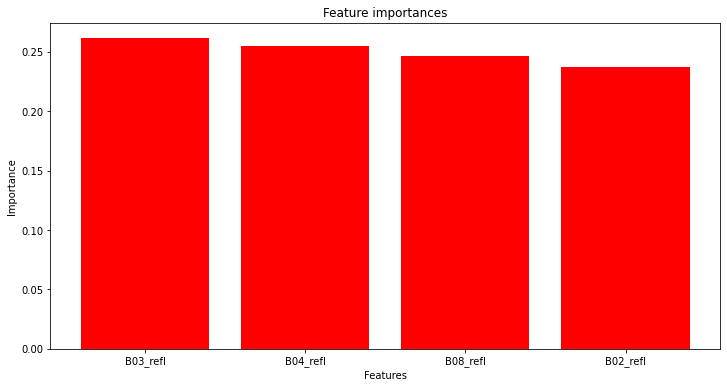

In [38]:
from sklearn.metrics import r2_score, log_loss
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# R2 score
y_pred_train = model.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)
y_pred_test = model.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)
print(f"Train R2 score: {r2_train}")
print(f"Test R2 score: {r2_test}")


# Gini importance
features = ['B02_refl', 'B03_refl', 'B04_refl', 'B08_refl']
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title("Feature importances")
plt.bar(range(len(features)), importances[indices], color="r", align="center")
plt.xticks(range(len(features)), [features[i] for i in indices])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()


# Support Vector Machine

Helps in the categorization of data points, even when the fields are not linearly separable

Iteration done till 85% accuracy (enters an endless loop, if I try to make the accuracy any more)

Training Set: 0.6
Testing Set: 0.4

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


ndf = ndf[['Crop_class', 'B02_refl', 'B03_refl', 'B04_refl', 'B08_refl']]

le = LabelEncoder()
ndf['Crop_class'] = le.fit_transform(ndf['Crop_class'])

X_train, X_test, y_train, y_test = train_test_split(ndf.drop('Crop_class', axis=1), ndf['Crop_class'], test_size=0.4, random_state=42)

model = SVC(kernel='linear', C=1, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Iterate to improve accuracy
while accuracy < 0.85:
    onion_indices = ndf[ndf['Crop_class'] == le.transform(['onion'])[0]].index

    # Split the data into training and testing sets, ensuring that there are onion crops in both sets
    X_train = ndf[df.index.isin(onion_indices) | ~ndf['Crop_class'].isin(onion_indices)].drop('Crop_class', axis=1)
    y_train = ndf[df.index.isin(onion_indices) | ~ndf['Crop_class'].isin(onion_indices)]['Crop_class']
    X_test = ndf[df.index.isin(onion_indices)].drop('Crop_class', axis=1)
    y_test = ndf[df.index.isin(onion_indices)]['Crop_class']

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    

print(f"Final accuracy: {accuracy}")


Final accuracy: 0.8660103797676909


# Evaluation of SVM

Among the three models I decided to use, SVM has the leat accuracy, but perhaps is also the least susceptible to overfitting. 

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')


print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.8660103797676909
Precision: 1.0
Recall: 0.8660103797676909
F1 Score: 0.928194600799064


C:\Users\pooja\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Random Forest Classifier

Works on the principle of multiple decision trees, taking majority votes for classification

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score



ndf2 = ndf2[['Crop_class', 'B02_refl', 'B03_refl', 'B04_refl', 'B08_refl']]


le = LabelEncoder()
ndf2['Crop_class'] = le.fit_transform(ndf2['Crop_class'])


X_train, X_test, y_train, y_test = train_test_split(ndf2.drop('Crop_class', axis=1), ndf2['Crop_class'], test_size=0.4, random_state=42)


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Iterate to improve accuracy
while accuracy < 0.9:
    
    onion_indices = ndf2[ndf2['Crop_class'] == le.transform(['onion'])[0]].index

    # Split the data into training and testing sets, ensuring that there are onion crops in both sets
    X_train = ndf2[df.index.isin(onion_indices) | ~ndf2['Crop_class'].isin(onion_indices)].drop('Crop_class', axis=1)
    y_train = ndf2[df.index.isin(onion_indices) | ~ndf2['Crop_class'].isin(onion_indices)]['Crop_class']
    X_test = ndf2[df.index.isin(onion_indices)].drop('Crop_class', axis=1)
    y_test = ndf2[df.index.isin(onion_indices)]['Crop_class']

    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    
print(f"Final accuracy: {accuracy}")


Final accuracy: 0.9696021089051816


# Evaluation of Random Forest

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')


print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9696021089051816
Precision: 1.0
Recall: 0.9696021089051816
F1 Score: 0.9845664812413735


C:\Users\pooja\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train R2 score: 0.8725537265086125
Test R2 score: 0.0


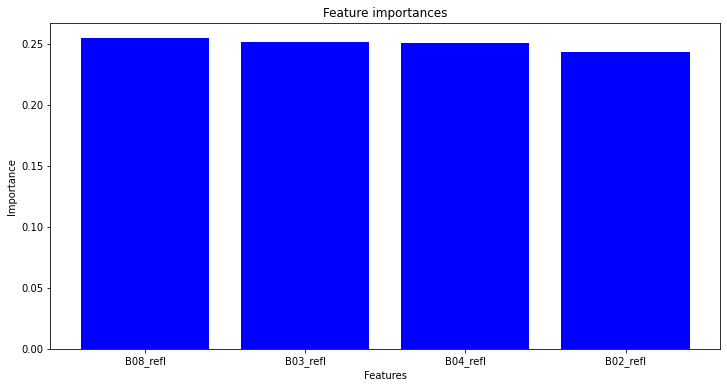

In [45]:
from sklearn.metrics import r2_score, log_loss
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# R2 score
y_pred_train = model.predict(X_train)
r2_train = r2_score(y_train, y_pred_train)
y_pred_test = model.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)
print(f"Train R2 score: {r2_train}")
print(f"Test R2 score: {r2_test}")


# Gini importance
features = ['B02_refl', 'B03_refl', 'B04_refl', 'B08_refl']
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title("Feature importances")
plt.bar(range(len(features)), importances[indices], color="b", align="center")
plt.xticks(range(len(features)), [features[i] for i in indices])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()